# **M Anwaar Khan Niazi**
# **BS: Data Science**

# **EyE Diease Using CNN**

# **Libraries**

In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# **Preprocessing**

In [2]:
# Define rescaling layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\dataset",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess train dataset (rescale)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Load validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\dataset",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess validation dataset (rescale)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\dataset",  # Specify the directory for the test dataset
    batch_size=32,
    image_size=(256, 256),
    label_mode='categorical',  # Assuming you have multiple classes
    shuffle=False,
)

# Preprocess test dataset (rescale)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.
Found 4217 files belonging to 4 classes.


# **Check Shape After Preprocessing**

In [3]:
# Check the first image shape in the training dataset
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
# Check the first image shape in the validation dataset
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
# Check the first image shape in the test dataset
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

Shape of the first image in the training dataset: (256, 256, 3)
Shape of the first image in the validation dataset: (256, 256, 3)
Shape of the first image in the test dataset: (256, 256, 3)


# **Check Pixel Value After Preprocessing**

In [5]:
# Initialize variables to store minimum and maximum pixel values
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

# Iterate through the dataset
for images, _ in train_ds:
    # Compute the minimum and maximum pixel values in the current batch of images
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)
    
    # Update overall minimum and maximum pixel values
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

# Print the minimum and maximum pixel values
print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())

Minimum pixel value: 0.0
Maximum pixel value: 1.0


# **Visualization**

In [6]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## **Cataract**

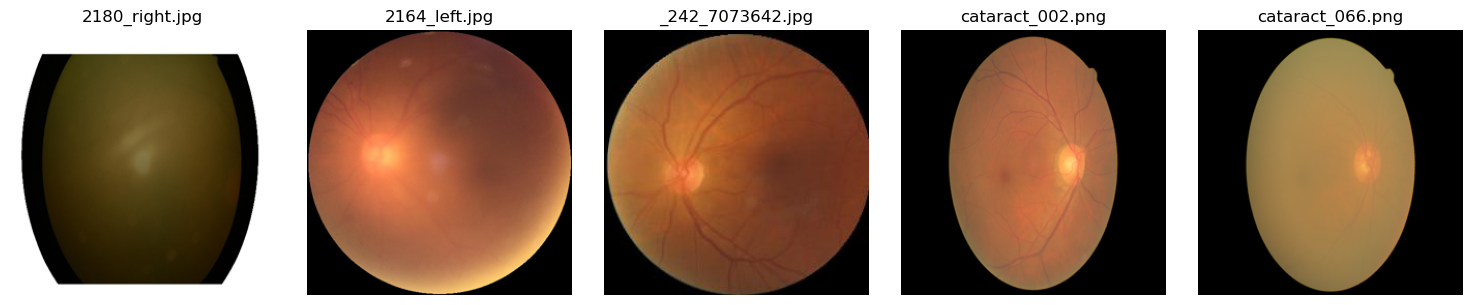

In [7]:
# Specify the path containing the images to visualize
path_to_visualize = "E:/dataset/cataract"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

## **Diabetic-Retinopathy**

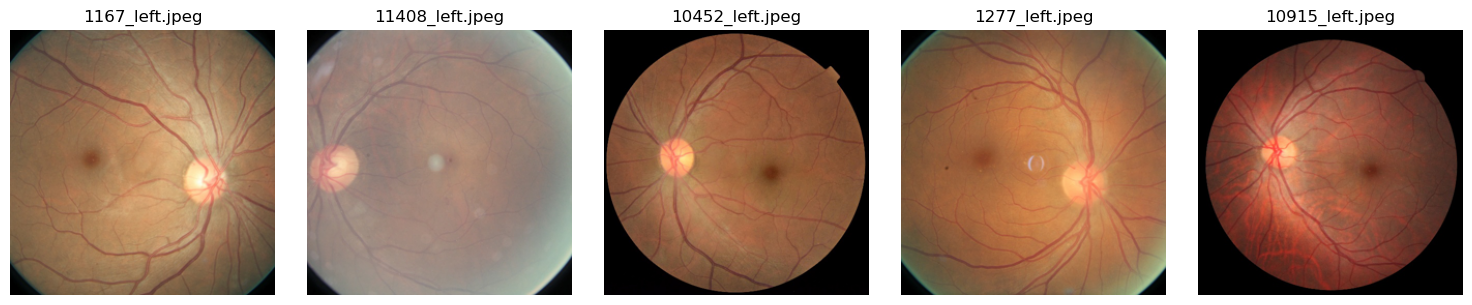

In [8]:
# Specify the path containing the images to visualize
path_to_visualize = "E:/dataset/diabetic_retinopathy"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

## **Normal**

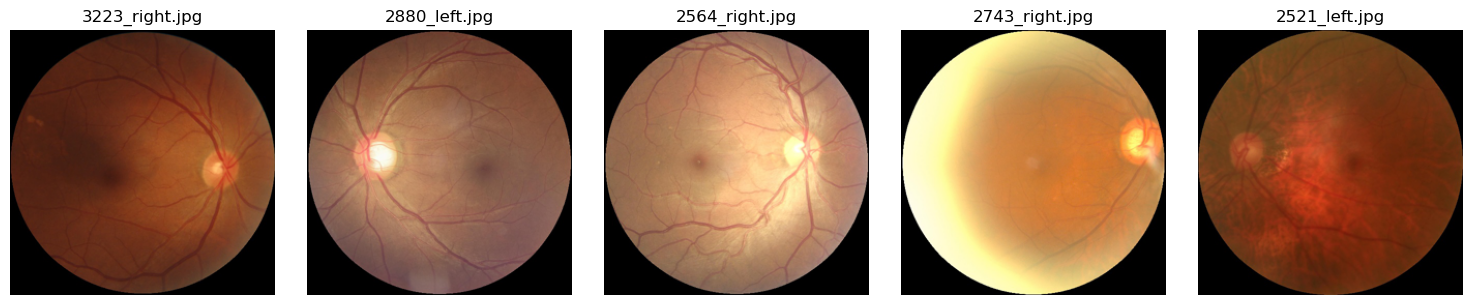

In [15]:
# Specify the path containing the images to visualize
path_to_visualize = "E:/dataset/normal"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

## **Glaucoma**

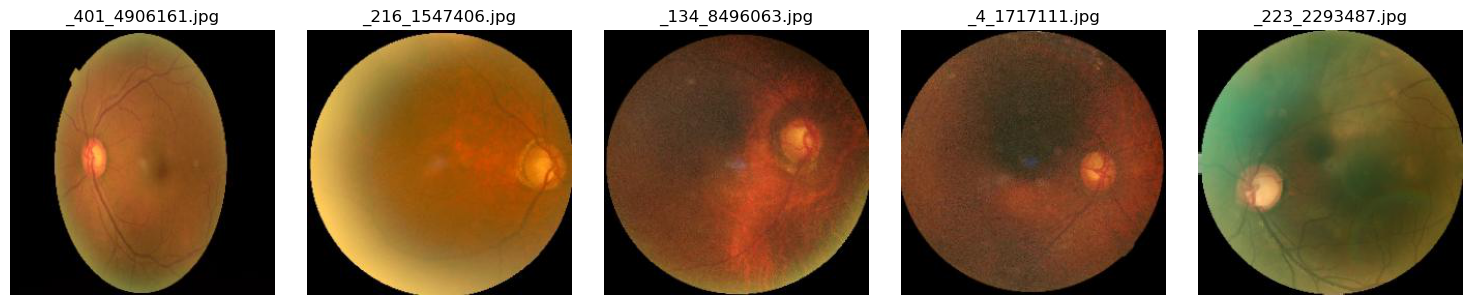

In [9]:
# Specify the path containing the images to visualize
path_to_visualize = "E:/dataset/glaucoma"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# **Model**

## **Build Model & Check Summary**

In [10]:
# Define the CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Print the model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,743,044 (14.28 MB)

 Trainable params: 3,743,044 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

# **Compile the model**

In [11]:
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# **Fit Model**

In [12]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(train_ds,
                        validation_data=validation_ds,
                        epochs=10,
                        callbacks=[early_stopping])

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4548 - loss: 1.2482 - val_accuracy: 0.6619 - val_loss: 0.7578
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6708 - loss: 0.7197 - val_accuracy: 0.7260 - val_loss: 0.6435
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7394 - loss: 0.5998 - val_accuracy: 0.7461 - val_loss: 0.5904
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7780 - loss: 0.5244 - val_accuracy: 0.7770 - val_loss: 0.5435
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7924 - loss: 0.4893 - val_accuracy: 0.7770 - val_loss: 0.5520
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8133 - loss: 0.4568 - val_accuracy: 0.7888 - val_loss: 0.5161
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8302 - loss: 0.4257 - val_accuracy: 0.7900 - val_loss: 0.5060
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8333 - loss: 0.4068 - val_accu

# **Evaluate the model** 

In [13]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)

132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 332ms/step - accuracy: 0.7845 - loss: 0.4640
Test accuracy: 0.8446763157844543


# **History Plot**

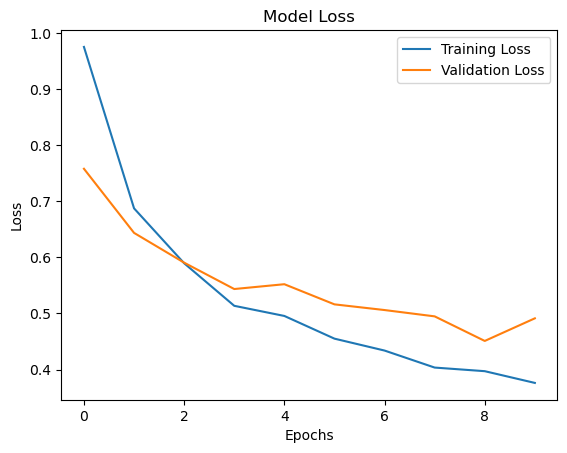

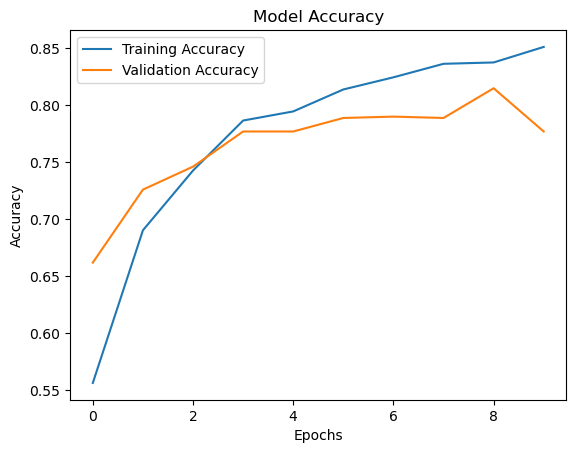

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()